this is a helper notebook to make holdout data for msr_action

# run.py

In [1]:
import argparse
import train
import test
import evaluate
import pandas as pd

c:\Users\Efran\anaconda3\envs\tpatches_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
GPU_IDX=0
CUDA_DEVICE_ORDER="PCI_BUS_ID"
CUDA_VISIBLE_DEVICES=GPU_IDX


#? setup arg parser to pass in config info
parser = argparse.ArgumentParser()
parser.add_argument('--logdir', type=str, default='./log/', help='path to model save dir')
parser.add_argument('--loglevel', type=str, default='info', help='set level of logger')
parser.add_argument('--identifier', type=str, default='debug', help='unique run identifier')
parser.add_argument('--config', type=str, default='./configs/dfaust/config_dfaust.yaml', help='path to yaml config file')
parser.add_argument('--model_ckpt', type=str, default='000000.pt', help='checkpoint to load')
parser.add_argument('--fix_random_seed', action='store_true', default=False, help='fix random seed')
args = parser.parse_args([])

#? Manually set arg parser values here:
#? Comment out if you want to use terminal flags above instead (I just got tired of manually entering them in)
args.logdir = './log/'
args.loglevel = 'debug'
args.identifier = 'debug_msr_action_3'
#args.identifier = 'set_transformer_dbug'
args.config = r'configs\msr-action3d\config_msr_action3d_temporal_0.yaml'
args.model_ckpt = '000001.pt'
args.fix_random_seed = True
print('args', args)

args Namespace(config='configs\\msr-action3d\\config_msr_action3d_temporal_0.yaml', fix_random_seed=True, identifier='debug_msr_action_3', logdir='./log/', loglevel='debug', model_ckpt='000001.pt')


# train.py

In [6]:

# Author: Yizhak Ben-Shabat (Itzik), 2022
# train 3DInAction

import os
import yaml
import argparse
import i3d_utils as utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import json

from models.pointnet import feature_transform_regularizer
from models import build_model
from datasets import build_dataloader

#import wandb
from tqdm import tqdm

import logging

def create_basic_logger(logdir, level = 'info'):
    print(f'Using logging level {level} for train.py')
    global logger
    logger = logging.getLogger('train_logger')
    
    #? set logging level
    if level.lower() == 'debug':
        logger.setLevel(logging.DEBUG)
    elif level.lower() == 'info':
        logger.setLevel(logging.INFO)
    elif level.lower() == 'warning':
        logger.setLevel(logging.WARNING)
    elif level.lower() == 'error':
        logger.setLevel(logging.ERROR)
    elif level.lower() == 'critical':
        logger.setLevel(logging.CRITICAL)
    else:
        logger.setLevel(logging.INFO)
    
    #? create handlers
    file_handler = logging.FileHandler(os.path.join(logdir, "log_train.log"))
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    
    stream_handler = logging.StreamHandler()
    #stream_handler.setLevel(logging.INFO)
    #stream_handler.setFormatter(stream_handler)
    logger.addHandler(stream_handler)
    return logger

In [7]:
cfg = yaml.safe_load(open(args.config))
logdir = os.path.join(args.logdir, args.identifier)
os.makedirs(logdir, exist_ok=True)

logger = create_basic_logger(logdir = logdir, level = args.loglevel)

# TODO: move to cfg project_name, entity
if cfg['DATA'].get('name') == 'DFAUST':
    project_name = 'DFAUST'
elif cfg['DATA'].get('name') == 'IKEA_EGO':
    project_name = 'IKEA EGO'
elif cfg['DATA'].get('name') == 'IKEA_ASM':
    project_name = 'IKEA ASM'
elif cfg['DATA'].get('name') == 'MSR-Action3D':
    project_name = 'MSR-Action3D'
else:
    raise NotImplementedError

logger.info(f'=================== Starting training run for {args.identifier} with data {project_name}')
logger.info(cfg)


#wandb_run = wandb.init(project=project_name, entity='mkjohn', save_code=True)
#cfg['WANDB'] = {'id': wandb_run.id, 'project': wandb_run.project, 'entity': wandb_run.entity}

with open(os.path.join(logdir, 'config.yaml'), 'w') as outfile:
    yaml.dump(cfg, outfile, default_flow_style=False)
    
logger.info(f'saving outputs for this run too: {logdir}')

#wandb_run.name = args.identifier
#wandb.config.update(cfg)  # adds all the arguments as config variables
#wandb.run.log_code(".")
# define our custom x axis metric
#wandb.define_metric("train/step")
#wandb.define_metric("train/*", step_metric="train/step")
#wandb.define_metric("test/*", step_metric="train/step")

=================== Starting training run for debug_msr_action_3 with data MSR-Action3D
{'DATA': {'data_sampler': 'weighted', 'dataset_path': 'datasets\\data\\MSRAction3D_fps_new\\train', 'dataset_path_test': 'datasets\\data\\MSRAction3D_fps_new\\test', 'frame_skip': 1, 'frames_per_clip': 64, 'gender': 'all', 'n_points': 128, 'name': 'MSR-Action3D', 'noisy_data': {'test': False, 'train': False}, 'shuffle_points': 'fps_each_frame'}, 'MODEL': {'3DMFV': {'n_gaussians': 8}, 'P4TRANSFORMER': {'depth': 10, 'dim': 1024, 'dim_head': 256, 'dropout1': 0.05, 'dropout2': 0.5, 'emb_relu': False, 'heads': 8, 'mlp_dim': 2048, 'nsamples': 32, 'radius': 0.1, 'spatial_stride': 32, 'temporal_kernel_size': 3, 'temporal_stride': 2}, 'PSTNET': {'nsamples': 9, 'radius': 0.1}, 'PST_TRANSFORMER': {'depth': 5, 'dim': 1024, 'dim_head': 256, 'dropout1': 0.0, 'dropout2': 0.5, 'heads': 8, 'mlp_dim': 2048, 'nsamples': 32, 'radius': 0.1, 'spatial_stride': 32, 'temporal_kernel_size': 3, 'temporal_stride': 2}, 'SET_TRA

saving outputs for this run too: ./log/debug_msr_action_3


Using logging level debug for train.py


In [8]:
n_epochs = cfg['TRAINING']['n_epochs']
lr = cfg['TRAINING']['lr']
batch_size = cfg['TRAINING']['batch_size']
refine, refine_epoch = cfg['TRAINING']['refine'], cfg['TRAINING']['refine_epoch']
pretrained_model = cfg['TRAINING']['pretrained_model']
pc_model = cfg['MODEL']['pc_model']
frames_per_clip = cfg['DATA']['frames_per_clip']
num_steps_per_update = cfg['TRAINING']['steps_per_update']
save_every = cfg['save_every']

if args.fix_random_seed:
    seed = cfg['seed']
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

back_file = os.path.join(logdir, 'train.py')
models_backup_path = os.path.join(logdir, 'models')
os.makedirs(models_backup_path, exist_ok=True)

temp = r'F:\Classes\COMPSCI 674 - Intelligent Visual Computing\Project\CS-674-Final-Project-3dInAction\train.py'

if os.name == 'nt':
    os.system(f'copy "{temp}" "{back_file}"') # backup the current training file
    for file in os.listdir('models'):
        if file.endswith('.py'):
            current_file = os.path.join('models', file)
            new_file=os.path.join(models_backup_path, file)
            os.system(f'copy "{current_file}" "{new_file}"')
else:
    os.system(f'cp "{temp}" "{back_file}"') # backup the current training file
    os.system(f'cp "models/*.py" "{models_backup_path}"')  # backup the models files
    
logger.debug(f'backed up the current training file: {(temp, back_file)}')
logger.debug(f'backup the models files: models/*.py, {models_backup_path}')

backed up the current training file: ('F:\\Classes\\COMPSCI 674 - Intelligent Visual Computing\\Project\\CS-674-Final-Project-3dInAction\\train.py', './log/debug_msr_action_3\\train.py')
backup the models files: models/*.py, ./log/debug_msr_action_3\models


In [9]:
# build dataloader and dataset
train_dataloader, train_dataset = build_dataloader(config=cfg, training=True, shuffle=False, logger=logger) # should be unshuffled because of sampler
test_dataloader, test_dataset = build_dataloader(config=cfg, training=False, shuffle=True, logger=logger)

Number of clips in the train set: 1402
Using MSR-Action3D for training
Number of clips in the test set: 102


#### getting holdout

In [12]:
import torch
import pickle
import numpy as NumPy
import torch.cuda as tcuda
import os
import random
dataset_path = f'datasets\data\MSRAction3D_fps'

In [75]:
with open(os.path.join(dataset_path, 'MSRAction3D_FPS_Videos.pickle') , mode = 'rb') as msr_action3d_pickle_file:
      msr_action3d_depth_map_sequences = pickle.load(msr_action3d_pickle_file)
msr_action3d_depth_map_sequence_labels = NumPy.load(os.path.join(dataset_path, 'MSRAction3D_FPS_Video_Labels.npz'))['labels']

print(len(msr_action3d_depth_map_sequences), len(msr_action3d_depth_map_sequence_labels))
print(type(msr_action3d_depth_map_sequences), type(msr_action3d_depth_map_sequence_labels))

567 567
<class 'list'> <class 'numpy.ndarray'>


#### create holdout alt

In [139]:
temp = list(zip(msr_action3d_depth_map_sequences, msr_action3d_depth_map_sequence_labels))
print(len(temp))

size = len(msr_action3d_depth_map_sequence_labels)
choice_pos = random.sample(range(size), k=int(size*.10))
print(len(choice_pos), choice_pos)

train = []
holdout = []

indices = range(size)
for i in indices:
    if i in choice_pos:
        holdout.append(temp[i])
    else:
        train.append(temp[i])
        

567
56 [68, 451, 549, 116, 99, 157, 168, 346, 424, 222, 551, 257, 360, 362, 260, 519, 11, 532, 64, 430, 113, 470, 75, 102, 466, 150, 391, 189, 418, 34, 352, 435, 285, 289, 144, 85, 454, 559, 321, 193, 45, 225, 455, 139, 552, 201, 290, 210, 271, 56, 525, 375, 291, 393, 134, 37]


array([[<Axes: title={'center': '0'}>]], dtype=object)

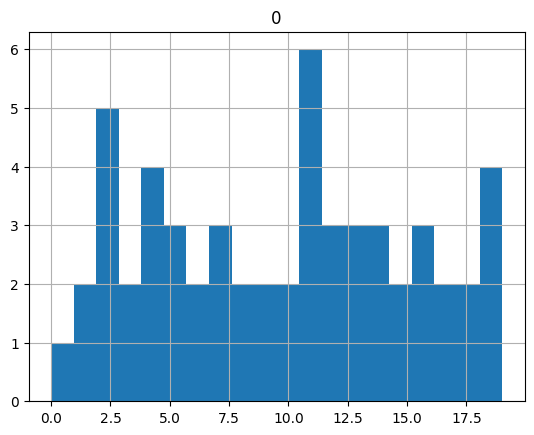

In [141]:
holdout_msr_action3d_depth_map_sequences = [x[0] for x in holdout]
holdout_msr_action3d_depth_map_sequence_labels = np.array([x[1] for x in holdout])
pd.DataFrame(holdout_msr_action3d_depth_map_sequence_labels).hist(bins=20)

In [146]:
#? saving holdout
with open(r'datasets\data\MSRAction3D_fps_new_2\test\MSRAction3D_FPS_Videos.pickle', 'wb') as f:
    pickle.dump(holdout_msr_action3d_depth_map_sequences, f)
    
data = {"labels": holdout_msr_action3d_depth_map_sequence_labels}
np.savez(r'datasets\data\MSRAction3D_fps_new_2\test\MSRAction3D_FPS_Video_Labels.npz', **data)

array([[<Axes: title={'center': '0'}>]], dtype=object)

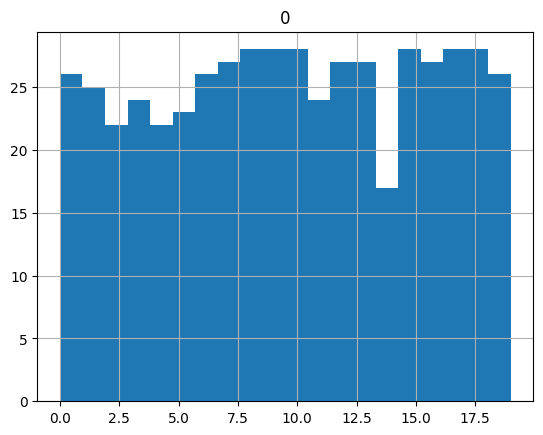

In [148]:
train_msr_action3d_depth_map_sequences = [x[0] for x in train]
train_msr_action3d_depth_map_sequence_labels = np.array([x[1] for x in train])
pd.DataFrame(train_msr_action3d_depth_map_sequence_labels).hist(bins=20)

In [149]:
#? saving holdout
with open(r'datasets\data\MSRAction3D_fps_new_2\train\MSRAction3D_FPS_Videos.pickle', 'wb') as f:
    pickle.dump(train_msr_action3d_depth_map_sequences, f)
    
data = {"labels": train_msr_action3d_depth_map_sequence_labels}
np.savez(r'datasets\data\MSRAction3D_fps_new_2\train\MSRAction3D_FPS_Video_Labels.npz', **data)

# making holdouts old

In [199]:
size = len(msr_action3d_depth_map_sequence_labels)
choice_pos = random.sample(range(size), k=int(size*.10))
choice_pos.sort()
print(choice_pos)

#? holdout
new_msr_action3d_depth_map_sequences = []
new_msr_action3d_depth_map_sequence_labels = []

indices = range(size)
for i in indices:
    if i in choice_pos:
        new_msr_action3d_depth_map_sequences.append(msr_action3d_depth_map_sequences[i])
        new_msr_action3d_depth_map_sequence_labels.append(msr_action3d_depth_map_sequence_labels[i])

new_msr_action3d_depth_map_sequence_labels = np.array(new_msr_action3d_depth_map_sequence_labels)

print(len(new_msr_action3d_depth_map_sequences), len(new_msr_action3d_depth_map_sequence_labels))
print(type(new_msr_action3d_depth_map_sequences), type(new_msr_action3d_depth_map_sequence_labels))

[10, 11, 21, 27, 46, 54, 63, 68, 78, 83, 88, 105, 129, 131, 137, 148, 160, 161, 171, 172, 185, 190, 204, 214, 217, 238, 248, 249, 253, 254, 256, 264, 282, 306, 308, 353, 390, 394, 397, 405, 421, 422, 427, 456, 461, 471, 505, 517, 521, 523, 536, 538, 545, 546, 557, 564]
56 56
<class 'list'> <class 'numpy.ndarray'>


array([[<Axes: title={'center': '0'}>]], dtype=object)

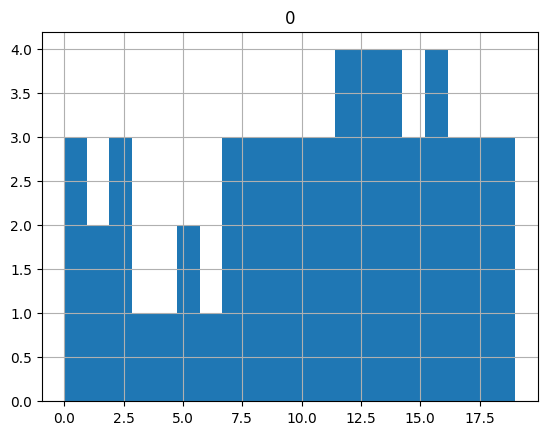

In [200]:
pd.DataFrame(new_msr_action3d_depth_map_sequence_labels).hist(bins=20)

In [201]:

#? saving holdout
with open(r'datasets\data\MSRAction3D_fps_new\test\MSRAction3D_FPS_Videos.pickle', 'wb') as f:
    pickle.dump(new_msr_action3d_depth_map_sequences, f)
    
data = {"labels": new_msr_action3d_depth_map_sequence_labels}
np.savez(r'datasets\data\MSRAction3D_fps_new\test\MSRAction3D_FPS_Video_Labels.npz', **data)

In [202]:

#? checking
with open(r'datasets\data\MSRAction3D_fps_new\test\MSRAction3D_FPS_Videos.pickle' , mode = 'rb') as msr_action3d_pickle_file:
      test_msr_action3d_depth_map_sequences = pickle.load(msr_action3d_pickle_file)
test_msr_action3d_depth_map_sequence_labels = NumPy.load(r'datasets\data\MSRAction3D_fps_new\test\MSRAction3D_FPS_Video_Labels.npz')['labels']

print(len(test_msr_action3d_depth_map_sequences), len(test_msr_action3d_depth_map_sequence_labels))
print(type(test_msr_action3d_depth_map_sequences), type(test_msr_action3d_depth_map_sequence_labels))
np.equal(new_msr_action3d_depth_map_sequence_labels, test_msr_action3d_depth_map_sequence_labels)

56 56
<class 'list'> <class 'numpy.ndarray'>


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

# making train set

In [204]:
#? holdout
new_msr_action3d_depth_map_sequences = []
new_msr_action3d_depth_map_sequence_labels = []

indices = range(size)
for i in indices:
    if i not in choice_pos:
        new_msr_action3d_depth_map_sequences.append(msr_action3d_depth_map_sequences[i])
        new_msr_action3d_depth_map_sequence_labels.append(msr_action3d_depth_map_sequence_labels[i])

new_msr_action3d_depth_map_sequence_labels = np.array(new_msr_action3d_depth_map_sequence_labels)

print(len(new_msr_action3d_depth_map_sequences), len(new_msr_action3d_depth_map_sequence_labels))
print(type(new_msr_action3d_depth_map_sequences), type(new_msr_action3d_depth_map_sequence_labels))

511 511
<class 'list'> <class 'numpy.ndarray'>


array([[<Axes: title={'center': '0'}>]], dtype=object)

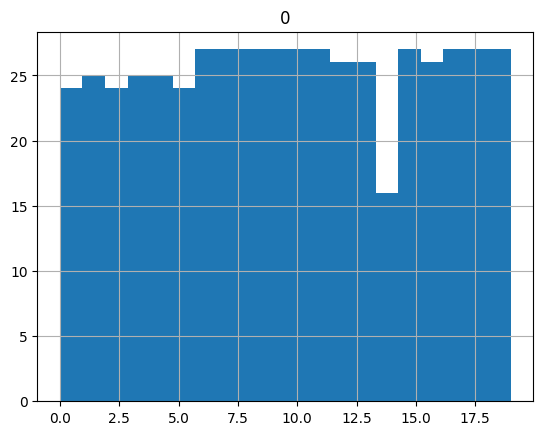

In [205]:
pd.DataFrame(new_msr_action3d_depth_map_sequence_labels).hist(bins=20)

In [206]:

#? saving training set
with open(r'datasets\data\MSRAction3D_fps_new\train\MSRAction3D_FPS_Videos.pickle', 'wb') as f:
    pickle.dump(new_msr_action3d_depth_map_sequences, f)
    
data = {"labels": new_msr_action3d_depth_map_sequence_labels}
np.savez(r'datasets\data\MSRAction3D_fps_new\train\MSRAction3D_FPS_Video_Labels.npz', **data)

In [207]:

#? checking
with open(r'datasets\data\MSRAction3D_fps_new\train\MSRAction3D_FPS_Videos.pickle' , mode = 'rb') as msr_action3d_pickle_file:
      train_msr_action3d_depth_map_sequences = pickle.load(msr_action3d_pickle_file)
train_msr_action3d_depth_map_sequence_labels = NumPy.load(r'datasets\data\MSRAction3D_fps_new\train\MSRAction3D_FPS_Video_Labels.npz')['labels']

print(len(train_msr_action3d_depth_map_sequences), len(train_msr_action3d_depth_map_sequence_labels))
print(type(train_msr_action3d_depth_map_sequences), type(train_msr_action3d_depth_map_sequence_labels))
np.equal(new_msr_action3d_depth_map_sequence_labels, train_msr_action3d_depth_map_sequence_labels)

511 511
<class 'list'> <class 'numpy.ndarray'>


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [125]:
pd.DataFrame(train_msr_action3d_depth_map_sequence_labels).value_counts()

10    29
19    29
15    28
7     28
8     27
9     27
17    27
16    27
12    26
13    26
0     25
18    25
5     25
6     25
1     25
2     24
4     24
3     23
11    23
14    18
Name: count, dtype: int64